# LAB imbalanced-data

#### We will be using the `files_for_lab/customer_churn.csv` dataset to build a churn predictor.

#### ### Instructions

1. Load the dataset and explore the variables.
2. We will try to predict variable `Churn` using a logistic regression on variables `tenure`, `SeniorCitizen`,`MonthlyCharges`. * Essentially, churn represents the probability that someone will stop being a customer.
3. Extract the target variable.
4. Extract the independent variables and scale them.
5. Build the logistic regression model.
6. Evaluate the model.
7. Even a simple model will give us more than 70% accuracy. Why?
8. **Synthetic Minority Oversampling Technique (SMOTE)** is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply `imblearn.over_sampling.SMOTE` to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?
9. **Tomek links** are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. Apply `imblearn.under_sampling.TomekLinks` to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

#### Import csv file

In [2]:
churnData = pd.read_csv('customer_churn.csv')
churnData.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Check data info

In [3]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Check data balance for dependant variable - *it has quite a high imbalance

In [5]:
churnData['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [7]:
5174/(5174+1869)

0.7346301292063041

#### Checking other variables columns to get a grasp of the data set.

In [17]:
churnData['gender'].value_counts()

# Gender has close to a 50/50 relationship, so a first guess is that it will not be relevant information. 
# However, it might be wise to check how many positive churn values come from male and female clients.

Male      3555
Female    3488
Name: gender, dtype: int64

In [20]:
yes = churnData[churnData['Churn']=='Yes']

In [21]:
yes['gender'].value_counts()

## Again, 50/50 churn 'yes' value between male and female. We can drop 'gender'.

Female    939
Male      930
Name: gender, dtype: int64

In [22]:
churnData['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [16]:
5901/(5901+1142)

0.8378531875621185

In [23]:
yes['SeniorCitizen'].value_counts()

0    1393
1     476
Name: SeniorCitizen, dtype: int64

In [24]:
# Seniors churn rate
476/1142

0.4168126094570928

In [25]:
# Non seniors churn rate
1393/5901

# Visual Comparison shows that there is a relationship between senior citizenship and higher churn rate. 0.24 against 0.42

0.23606168446026096

In [26]:
churnData['tenure'].value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

In [11]:
churnData.shape

(7043, 21)

#### Check for NaN values in Dataset

In [9]:
churnData.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Check for correlation

In [27]:
churnData.corr()

,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.000000,0.016567,0.220173
tenure,0.016567,1.000000,0.247900
MonthlyCharges,0.220173,0.247900,1.000000


## •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

#### I move on with the exercise and make my df with columns 'tenure', 'SeniorCitizen', 'MonthlyCharges' and target 'Churn'

In [30]:
data = churnData[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'Churn']].copy()

In [31]:
data.head()

,tenure,SeniorCitizen,MonthlyCharges,Churn
0,1,0,29.85,No
1,34,0,56.95,No
2,2,0,53.85,Yes
3,45,0,42.30,No
4,2,0,70.70,Yes


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   SeniorCitizen   7043 non-null   int64  
 2   MonthlyCharges  7043 non-null   float64
 3   Churn           7043 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 220.2+ KB


In [32]:
data.describe()

,tenure,SeniorCitizen,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,0.162147,64.761692
std,24.559481,0.368612,30.090047
min,0.000000,0.000000,18.250000
25%,9.000000,0.000000,35.500000
50%,29.000000,0.000000,70.350000
75%,55.000000,0.000000,89.850000
max,72.000000,1.000000,118.750000


#### Splitting my data into dependant (y) and independent (X) variables.

In [39]:
y = pd.DataFrame(data=data, columns=['Churn'])
X = data.select_dtypes(include=['float64','int64'])

In [41]:
y.head()

,Churn
0,No
1,No
2,Yes
3,No
4,Yes


In [40]:
X.head()

,tenure,SeniorCitizen,MonthlyCharges
0,1,0,29.85
1,34,0,56.95
2,2,0,53.85
3,45,0,42.30
4,2,0,70.70


#### Scaling independant variables

In [42]:
transformer = StandardScaler().fit(X)
scaled_x = transformer.transform(X)

#### Splitting the model into Test and Train with a test size of 30%

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.3, random_state=100)

#### Checking the accuracy of my model

In [44]:
classification = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
y_predict = classification.predict(X_test)
print("The accuracy of the logistic_regression model is: %4.2f "% (classification.score(X_test, y_test)))

The accuracy of the logistic_regression model is: 0.78 


In [47]:
print("The accuracy of a blind guess is: %4.2f " % (5163/(5163+1869))) 

The accuracy of a blind guess is: 0.73 


#### I check the Kappa score to check bias in my model

In [48]:
from sklearn.metrics import cohen_kappa_score

print("The kappa of the logistic regression model is: %4.2f " %(cohen_kappa_score(y_predict,y_test)) )

The kappa of the logistic regression model is: 0.39 


In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict, labels=['Yes','No']))

              precision    recall  f1-score   support

         Yes       0.62      0.46      0.53       566
          No       0.82      0.90      0.86      1547

    accuracy                           0.78      2113
   macro avg       0.72      0.68      0.69      2113
weighted avg       0.77      0.78      0.77      2113



In [ ]:
# F1 takes into account both precision and recall, and scores the balance between both.

#### Confusion Matrix to check the accuracy visually

In [50]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(y_test, y_predict)

Confussion matrix



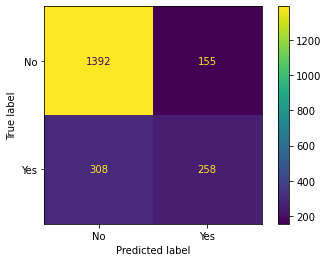

In [51]:
print("Confussion matrix")
plot_confusion_matrix(classification, X_test, y_test) 
print()

#### By observing the Matrix, we see that the model is quite good at predicting Churn labeled NO but very bad at predicting Churn labeled YES.

## •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

### Synthetic Minority Oversampling Technique (SMOTE)

#### I Assign new variables to X and y to avoid overlap with previous model

In [62]:
X_smote = X.copy()

In [63]:
X_smote.head()

,tenure,SeniorCitizen,MonthlyCharges
0,1,0,29.85
1,34,0,56.95
2,2,0,53.85
3,45,0,42.30
4,2,0,70.70


In [56]:
y_smote = y.copy()

In [57]:
y_smote.head()

,Churn
0,No
1,No
2,Yes
3,No
4,Yes


In [65]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

transformer = StandardScaler().fit(X_smote)
X_smote_scaled = transformer.transform(X_smote)
X_sm, y_sm = smote.fit_sample(X_smote_scaled, y_smote)
#y_sm = pd.DataFrame(data=y_sm.flatten())
y_sm.value_counts()

Yes    5174
No     5174
Name: Churn, dtype: int64

In [102]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)

In [103]:
classification = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train_smote, y_train_smote)
y_predict_smote = classification.predict(X_test_smote)
print("The accuracy of the logistic_regression model after undersampling is: %4.2f "% (classification.score(X_test_smote, y_test_smote)))

The accuracy of the logistic_regression model after undersampling is: 0.75 


In [104]:
from sklearn.metrics import cohen_kappa_score

print("The kappa of the logistic regression model after undersampling is: %4.2f " %(cohen_kappa_score(y_predict_smote,y_test_smote)) )

The kappa of the logistic regression model after undersampling is: 0.50 


In [105]:
from sklearn.metrics import classification_report

print(classification_report(y_test_smote, y_predict_smote, labels=['Yes','No']))

              precision    recall  f1-score   support

         Yes       0.75      0.75      0.75      1548
          No       0.75      0.75      0.75      1557

    accuracy                           0.75      3105
   macro avg       0.75      0.75      0.75      3105
weighted avg       0.75      0.75      0.75      3105



In [ ]:
# F1 takes into account both precision and recall, and scores the balance between both. 
# With the application of SMOTE, we get the most balanced results in this specific case.

## •••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

### Tomek links

In [76]:
X_tom = X.copy()

In [77]:
y_tom = y.copy()

In [84]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [90]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks('majority')
X_tl, y_tl = tl.fit_sample(X_tom_scaled, y_tom)

In [95]:
type(y_tl)

pandas.core.frame.DataFrame

In [97]:
pd.value_counts(y_tl.values.flatten())

No     4694
Yes    1869
dtype: int64

In [100]:
X_tl2, y_tl2 = tl.fit_sample(X_tl, y_tl)

In [101]:
pd.value_counts(y_tl2.values.flatten())

No     4537
Yes    1869
dtype: int64

In [106]:
X_train_tom, X_test_tom, y_train_tom, y_test_tom = train_test_split(X_tl2, y_tl2, test_size=0.3, random_state=100)

In [107]:
classification = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train_tom, y_train_tom)
y_predict_tom = classification.predict(X_test_tom)
print("The accuracy of the logistic_regression model after undersampling is: %4.2f "% (classification.score(X_test_tom, y_test_tom)))

The accuracy of the logistic_regression model after undersampling is: 0.79 


In [108]:
print("The kappa of the logistic regression model after undersampling is: %4.2f " %(cohen_kappa_score(y_predict_tom,y_test_tom)) )

The kappa of the logistic regression model after undersampling is: 0.46 


In [109]:
from sklearn.metrics import classification_report

print(classification_report(y_test_tom, y_predict_tom, labels=['Yes','No']))

              precision    recall  f1-score   support

         Yes       0.69      0.53      0.60       560
          No       0.82      0.90      0.86      1362

    accuracy                           0.79      1922
   macro avg       0.76      0.72      0.73      1922
weighted avg       0.78      0.79      0.79      1922



In [ ]:
# F1 takes into account both precision and recall, and scores the balance between both.